# Negative Sampling

지금까지 살펴본 모델은 사용자의 평점을 회귀 모델을 사용하여 예측을 하여 추천에 활용하기 위한 모델을 만들었습니다. 

평점은 아이템에 대한 직접적 피드에 해당되는데요.

조회한 아이템 내역과 같은 **간접적 피드백(Implicite Feedback)**을 활용하는 데 꼭 필요한 **Negative Sampling**에 대해서 알아봅니다.

응용이 가능한 분류 모델에 대해서 알아 봅니다.

# 다중분류(MultiClass Classfication)

대상 클래스가 2개가 넘는 분류 문제를 말합니다.

Logit은 [0, 1]의 확률 공간을 [-∞, ∞]의 실수 공간으로 변환한 값입니다.

이진분류에서는 참(True, Positive) 클래스에 대한 확률에 대한 Logit만을 고려하면 되지만, 

다중분류에서는 각의 클래스에 대한 Logit을 구해야 합니다. 

왜냐면 이진분류는 True 아니면 False이지만, 다중분류에서는 A가 아니면, B, C, ...D 이므로 각각에 대한 확률을 고려가 필요해서요.

클래스들의 Logit에서 클래스들의 확률을 구해주는 것이 SoftMax입니다.


간단한 예를 들어 보겠습니다.

Iris 데이터셋에서 붓꽃의 종류를 붓꽃의 각 부분의 사이즈로 맞추는 모델을 만들어 보겠습니다.

붓꽃의 총 종류는 3종류 입니다.

In [1]:
from sklearn.datasets import load_iris
import numpy as np

In [2]:
iris = load_iris(as_frame=True)
df_X = iris['data']
s_y = iris['target']
display(df_X.head(5))
display(s_y.head(5))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [3]:
import os
import gdown
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

2025-06-23 01:07:10.614046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750608430.624137   68098 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750608430.627392   68098 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750608430.636136   68098 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750608430.636154   68098 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750608430.636155   68098 computation_placer.cc:177] computation placer alr

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print("{} Physical GPUs, {} Logical GPUs".format(len(gpus), len(logical_gpus)))
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1750608432.213370   68098 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


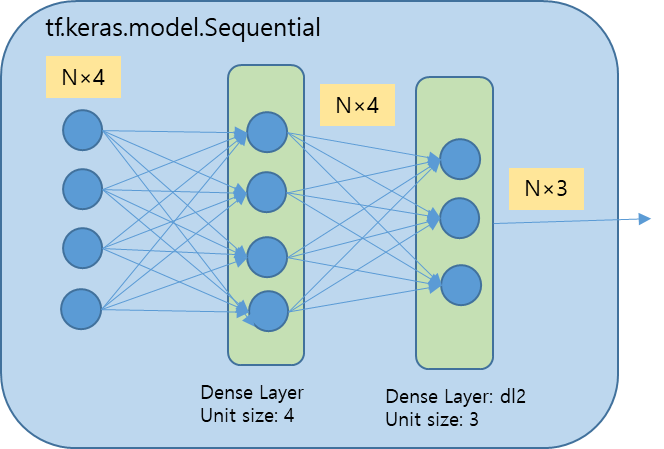

In [5]:
from sklearn.preprocessing import StandardScaler
# Tensorflow 데이터셋을 만듭니다. 
# Iris Dataset의 입력 변수를 표준화 합니다.
std_scaler = StandardScaler()
std_scaler.fit(df_X.values)
ds_iris = tf.data.Dataset.from_tensor_slices(
    (std_scaler.transform(df_X.values), s_y)
)

# 따로 Model을 상속받지 않고, tf.keras.models.Sequential(순차적 모델)을 정의합니다.
# 이용하여 모델을 정의해봅니다. 간단한 네트워크를 정의하기에 유용합니다.
# tf.keras.models
clf_iris = tf.keras.models.Sequential(name = 'iris')
# 입력 레이어를 추가합니다. 4개(sepal length (cm), sepal width (cm), petal length (cm), petal width (cm))
clf_iris.add(
    tf.keras.layers.Input(shape = (4, ), name = 'input')
)
# Unit의 수가 4개인 은닉층을 추가합니다. activation은 relu를 씁니다.
clf_iris.add(
    tf.keras.layers.Dense(4, activation = 'relu', kernel_initializer = 'he_uniform')
)
# Logit의 수가 3개(대상 변수의 Class가 3개)인 Layer를 추가합니다.
clf_iris.add(
    tf.keras.layers.Dense(3, kernel_initializer = 'glorot_uniform')
)

# 확률을 출력하고자 한다면 Softmax를 추가하고, compile단계에서 loss에 tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)로 설정합니다.
# clf_iris.add(tf.keras.layers.Softmax())
# Sparse
# 0, 1, 2
# Dense
# [1, 0, 0],
# [0, 1, 0],
# [0, 0, 1],
clf_iris.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # 분류에서 사용하는 대상 변수의 확률과 모델에서 주는 대상 변수의 확률간의 차이를 손실함수로 합니다.
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
clf_iris.fit(ds_iris.shuffle(100).batch(8), epochs=20)

Epoch 1/20


I0000 00:00:1750608432.990915   68293 service.cc:152] XLA service 0x7f336001a5d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750608432.990952   68293 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
I0000 00:00:1750608433.070024   68293 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/19 ━━━━━━━━━━━━━━━━━━━━ 12s 668ms/step - loss: 0.7812 - sparse_categorical_accuracy: 0.5000

I0000 00:00:1750608433.334032   68293 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8097 - sparse_categorical_accuracy: 0.6228
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5809 - sparse_categorical_accuracy: 0.7781
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4659 - sparse_categorical_accuracy: 0.8645
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4430 - sparse_categorical_accuracy: 0.8261
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4601 - sparse_categorical_accuracy: 0.7958
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4391 - sparse_categorical_accuracy: 0.8089
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3539 - sparse_categorical_accuracy: 0.8573
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3538 - sparse_categorical_accuracy: 0.8288
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3444 - sparse_categorical_accuracy: 0.8789
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3171 - sparse_categori

In [6]:
from sklearn.metrics import accuracy_score
# df_X를 입력으로 예측합니다. 
accuracy_score(
    s_y,
    np.argmax(clf_iris.predict(
        tf.constant(std_scaler.transform(df_X))
    ), axis = 1),
)

/home/sun9sun9/python312/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


0.9466666666666667

# 추천 문제에서 다중분류모델

Softmax 기반의 모델에서는 모델에서 출력하는 Logit의 수는 곧 대상 클래스의 수입니다.

- 추천 문제에 있어서는 Logit의 수가 곧 아이템의 수가 됩니다. 

- 아이템의 수가 많아 수록 Logit의 수는 많아지게 됩니다. 

-  따라서 모델의 Weight(가중치)의 수도 아이템의 수가 늘어남에 따라 모델의 크기가 커집니다.

- 이에 따른 연산 시간이 늘어 나고, 연산 자원 또한 많이 필요하게 됩니다.

**해결책**

리소스의 문제를 해결하기 위해 선별의 대상을 전체 아이템을 사용하지 않고

정답 클래스(Positive Class)를 제외한 비정답 클래스(Negative Classes)의 일부만을 선택해서 분류하게 합니다.

비정답 클래스의 일부만을 뽑아내는 기법을 **Negative Sampling**이라고 합니다.

Iris와 같이 모든 클래스를 가지고 Logit을 구성하는 모델을 사용해봅니다.

user id가 평점을 한 item id를 맞추는 모델을 만듭니다.

In [7]:
import pickle
import pandas as pd

# MovieLens 100K를 데이터셋을 불러옵니다.
df_ratings = pd.read_csv('dataset/ratings_100k.csv')
df_ratings['date'] = df_ratings.pop('timestamp').pipe(lambda x: pd.to_datetime(x, unit='s'))
df_user = pd.read_csv('dataset/users_100k.csv', index_col='user id')
df_movie = pd.read_csv('dataset/movies_100k.csv', index_col='movie id')

In [8]:
n_user = df_ratings['user id'].nunique()
n_user

943

In [9]:
df_ratings['user id'].agg(['min', 'max'])

min      1
max    943
Name: user id, dtype: int64

In [10]:
n_item = df_ratings['item id'].nunique()
n_item

1682

In [11]:
ds_10k = tf.data.Dataset.from_tensor_slices(
    (df_ratings['user id'], df_ratings['item id'] - 1)
)
for X, y in ds_10k.batch(32).take(1):
    print(X, y)

tf.Tensor(
[196 186  22 244 166 298 115 253 305   6  62 286 200 210 224 303 122 194
 291 234 119 167 299 291 308  95  38 102  63 160  50 301], shape=(32,), dtype=int64) tf.Tensor(
[ 241  301  376   50  345  473  264  464  450   85  256 1013  221   39
   28  784  386  273 1041 1183  391  485  143  117    0  545   94  767
  276  233  245   97], shape=(32,), dtype=int64)


In [12]:
# 입력변수는 user id, 대상 변수는 item id인 tensorflow 데이터셋을 만듭니다.
ds_10k = tf.data.Dataset.from_tensor_slices(
    (df_ratings['user id'], df_ratings['item id'] - 1)
)

clf_rating = tf.keras.models.Sequential(name='user')
# 입력 변수의 수가 1인 이름이 user id인 입력층을 추가합니다. N x 1
clf_rating.add(
    tf.keras.layers.Input(shape = (1, ), name = 'user id')
)
# 출력 임베딩 사이즈가 16인 임베딩 층을 추가합니다. N x 1 x 16
clf_rating.add(
    tf.keras.layers.Embedding(df_ratings['user id'].nunique() + 1,  16)
)
# 2차원으로 Tensor로 만듭니다. N x 16
clf_rating.add(
    tf.keras.layers.Flatten()
)
# 출력수가 n_item인 Logit을 출력하게 되는 밀도 레이어를 추가합니다. N x n_item
clf_rating.add(tf.keras.layers.Dense(n_item)) 

In [13]:
clf_rating.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)
clf_rating.fit(ds_10k.shuffle(100000).batch(256), epochs=30)

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 7.3468 - sparse_categorical_accuracy: 0.0044
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.8019 - sparse_categorical_accuracy: 0.0060
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.6960 - sparse_categorical_accuracy: 0.0052
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.6516 - sparse_categorical_accuracy: 0.0057
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.6047 - sparse_categorical_accuracy: 0.0069
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.5474 - sparse_categorical_accuracy: 0.0070
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.4854 - sparse_categorical_accuracy: 0.0076
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.4295 - sparse_categorical_accuracy: 0.0072
Epoch 9/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.3857 - sparse_categorical_accuracy: 0.0075
Epoch 10/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - 

```
clf_rating.add(tf.keras.layers.Embedding(n_user + 1, 16)) # N × 16
clf_rating.add(tf.keras.layers.Dense(n_item)) # N x n_item
```

대상 아이템의 수준의 수가 커지면 출력 Logit수도 그 만큼 증가하게 됩니다. 

따라서, 학습과 서비스에 필요한 리소스드 증가하게 됩니다.

대상 변수의 클래수가 1,500개 정도는 까지는 눈에 띄지 않지만,

Item이 많아질 수록 현저하게 성능이 떨어집니다.

## Negative Sampling

위의 MovieLens 10K로 구성한 네트워크 구조를 가지고 설명을 드립니다.

Dense Layer의 Weight Matrix Size는 16(출력 레이어에 입력되는 변수의수) x n_movie(대상 클레스 수) 입니다. 

Dense Layer의 Weight Matrix를 W 라하고, 

Bias는 고려하지 않습니다.

- I: Dense Layer에 입력 행렬 (N × 16)

- O: 출력 행렬 (N × n_movie)

- O = I × W

O의 i열은 i 번째 영화의 Logit 이고, W의 열벡터와 입력 Matrix각의 곱으로 나온 값입니다. 

W의 열벡터 중에서 Logit을 구하고자 하는 영화의 벡터만을 취하여 입력과 행렬곱을 하면 됩니다.

W의 각각 열벡터는 해당 Item의 임베딩이라고 할 수 있습니다.

Embedding Layer를 사용하여 샘플링한 아이템들만을 뽑아 출력층의 가중치를 만들어 행렬곱을 

통해 로짓을 만듭니다.


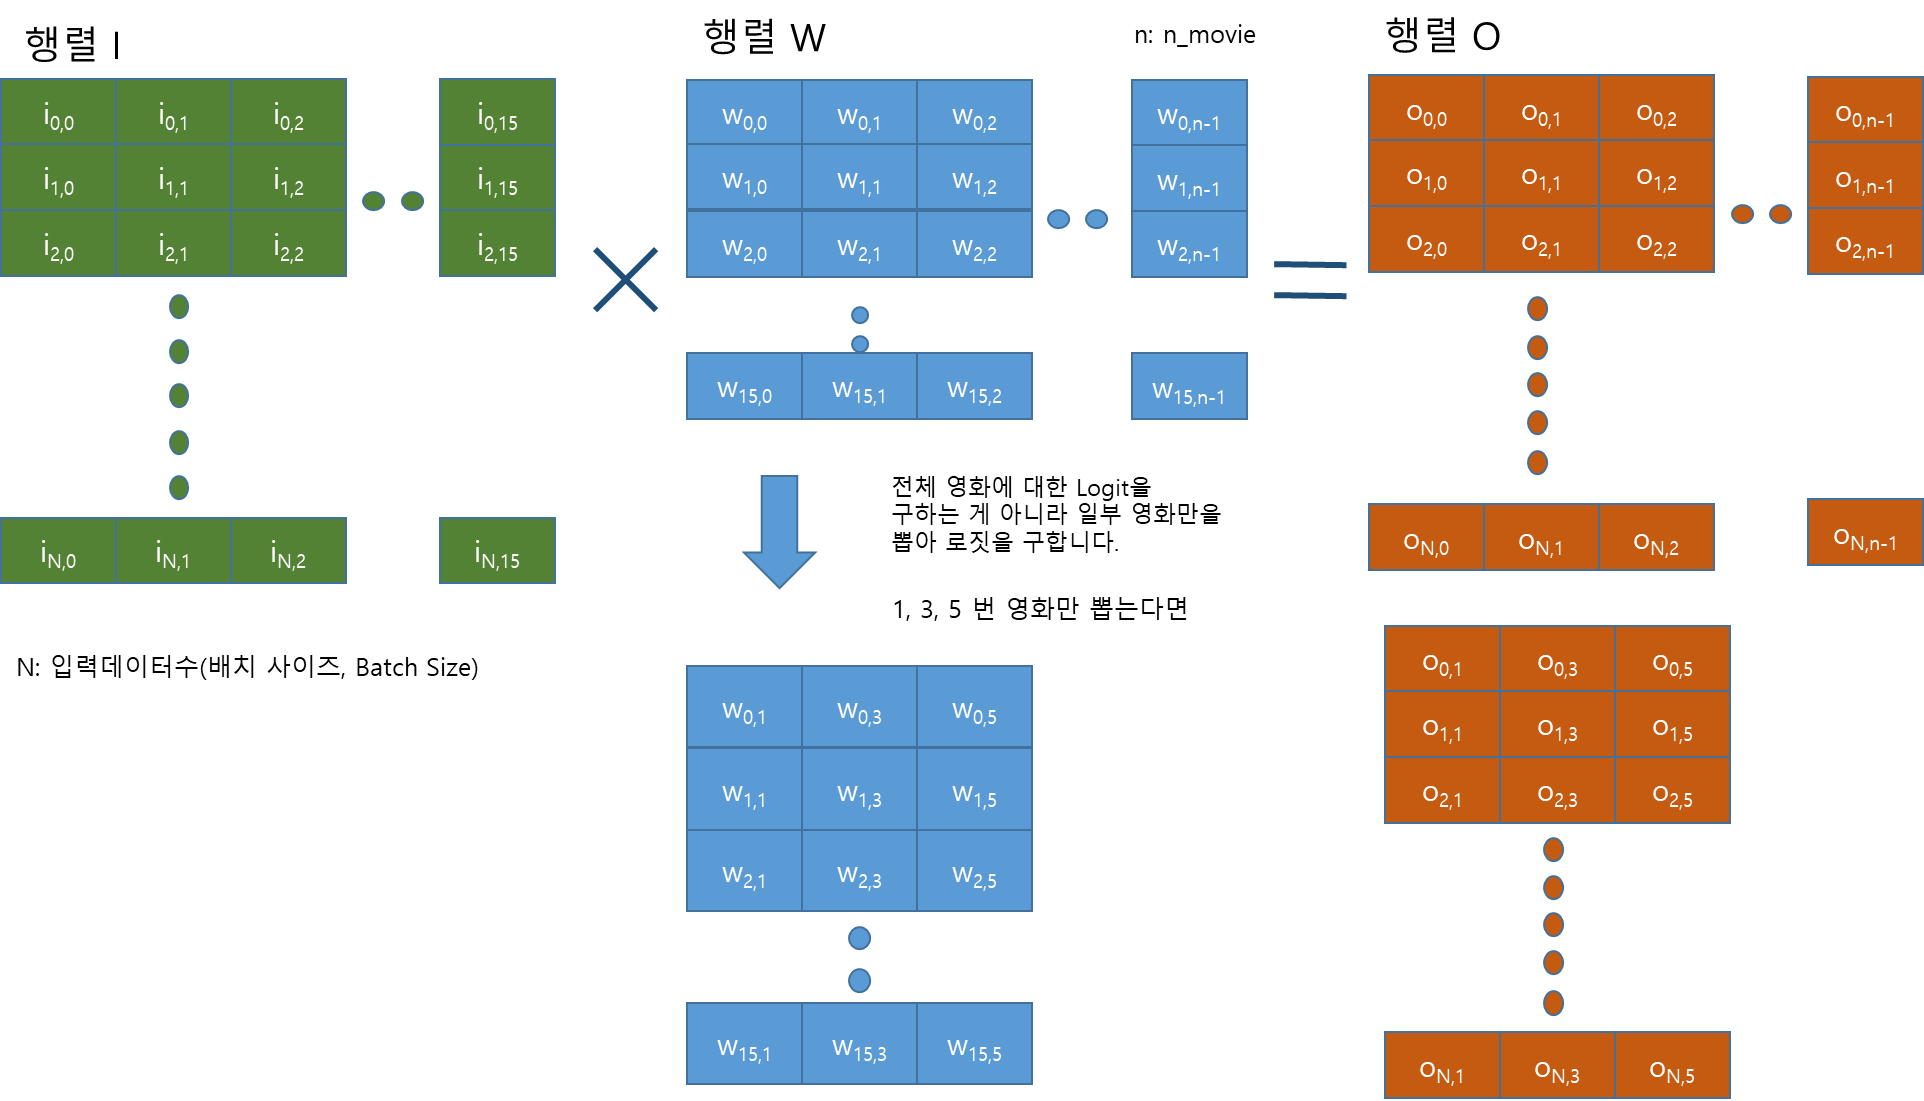

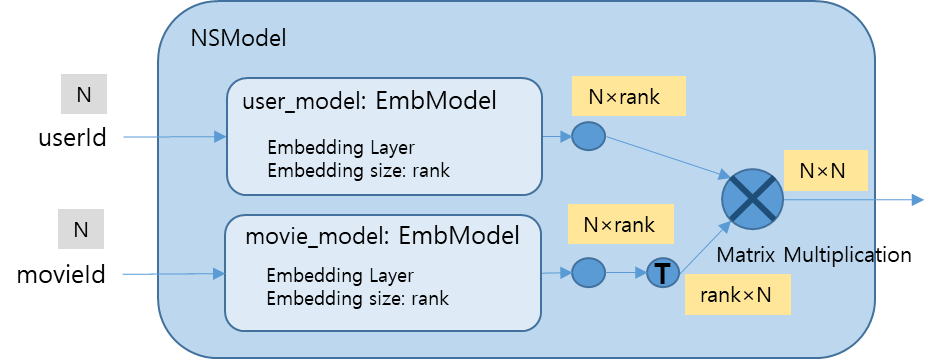

In [14]:
class NSModel(tf.keras.Model):
    def __init__(self, user_model, movie_model):
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        
    def call(self, x):
        I = user_model(x['user id'])
        W_prime_t = movie_model(x['movie id'])
        Logit = tf.matmul(I, W_prime_t, transpose_b = True)
        return Logit

그럼 Logit을 구할 movie_ids는 어떻게 선정(샘플링) 할까요

정답 Class은 있어야 하니, 모델 입력에 정답으로 등장하는 Class는 무조건 포함해야 합니다.

예를 들어,

movie_ids가 [1, 2, 3, 4, ..., 10] 이라면 

|user_id|movie_id|
|-|-|
|1|1|
|2|2|
|3|4|
|4|5| 

....

위의 4개에 대한 입력을 구성할 때는 
적어도 [1, 2, 4, 5]은 샘플링을 되고, 

user_id 1이 movie_id 2, 4, 5을 

user_id 2는 movie_id 1, 4, 5를, ...

즉 자신이 시청한 영화외는 보지 않았다고 가정하면

자신이 보지 않은 영화들은 자연스럽게 Negative Sample이 됩니다.

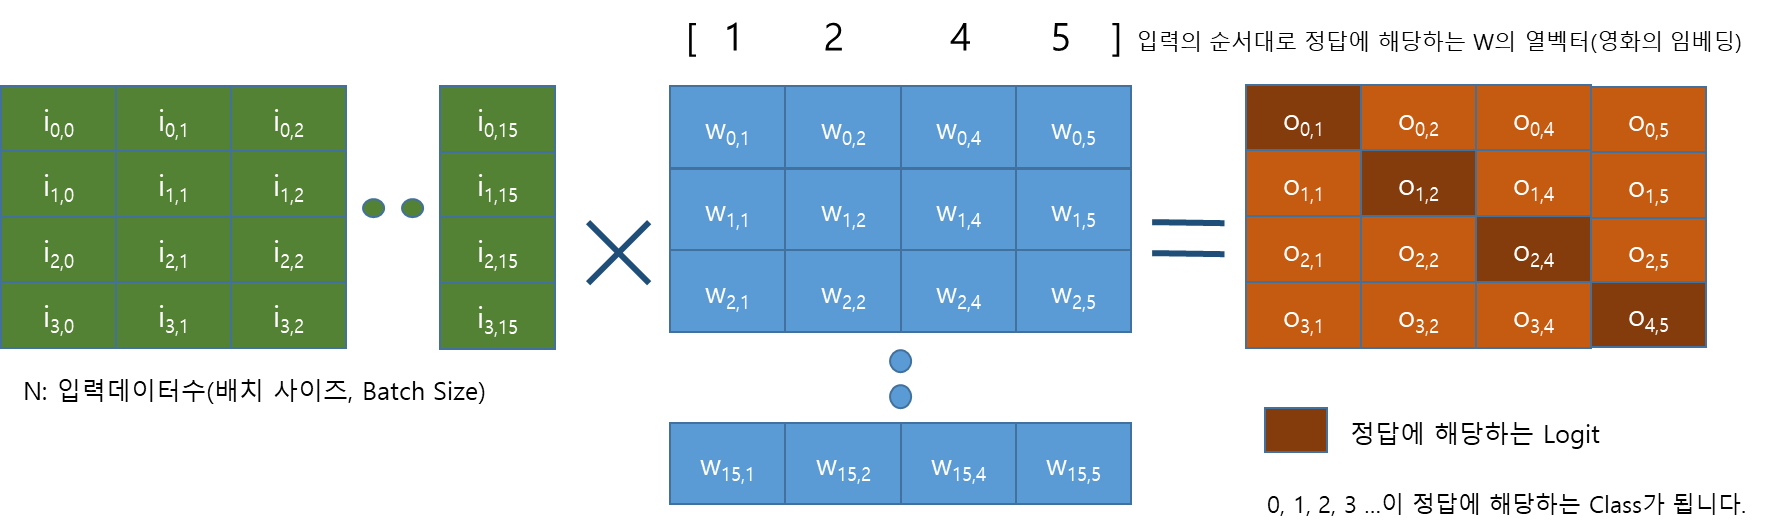

## MovieLens 10K에 적용해 봅니다.

In [15]:
# Matrix Factorization 3까지 만들었던 Model 들이 들어가 있습니다.
import rcmd
# 위 서사를 기반으로 모델을 구성합니다.
import numpy as np

In [16]:
tf.keras.backend.clear_session()
user_model = rcmd.EmbModel(df_ratings['user id'].unique(), 16)
movie_model = rcmd.EmbModel(df_ratings['item id'].unique(), 16)
clf_ns = NSModel(user_model, movie_model)

# 동작을 확인하기 위해 작은 사이즈의 구분단위로 구성합니다. 데이터셋을 구성해봅니다.
N = 4

ds_10k_ns = tf.data.Dataset.from_tensor_slices((
    {
        'user id': df_ratings['user id'], 
        'movie id': df_ratings['item id']
    }, 
    np.arange(0, len(df_ratings)) % N # Batch에서 첫번째는 0, 두번째는 1 순차적으로 정답이 됩니다.
)).batch(N)

In [17]:
np.arange(0, len(df_ratings))[:30] % 4

array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1,
       2, 3, 0, 1, 2, 3, 0, 1])

In [18]:
for i in ds_10k_ns.take(1):
    print('user id', i[0]['user id'])
    print('movie id', i[0]['movie id'])
    print('target', i[1])
    print(clf_ns(i[0]))

user id tf.Tensor([196 186  22 244], shape=(4,), dtype=int64)
movie id tf.Tensor([242 302 377  51], shape=(4,), dtype=int64)
target tf.Tensor([0 1 2 3], shape=(4,), dtype=int64)
tf.Tensor(
[[ 0.00501706  0.0045725  -0.00194089 -0.00421595]
 [ 0.00172827 -0.00411512  0.00022429 -0.00178052]
 [-0.00579643  0.00264607  0.00022068  0.00700361]
 [-0.0050086  -0.00612353  0.00205475 -0.00041834]], shape=(4, 4), dtype=float32)


In [19]:
# Batch의 크기는 128입니다.
N = 128
# 데이터셋을 구성해봅니다. 
ds_10k_ns = tf.data.Dataset.from_tensor_slices((
    {
        'user id': df_ratings['user id'], 
        'movie id': df_ratings['item id']
    }, 
    np.arange(0, len(df_ratings)) % N
)).batch(N)

In [20]:
clf_ns.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)
clf_ns.fit(ds_10k_ns, epochs=30)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.8508 - sparse_categorical_accuracy: 0.0081
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 142us/step - loss: 4.7653 - sparse_categorical_accuracy: 0.0189
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.6044 - sparse_categorical_accuracy: 0.0224
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.5229 - sparse_categorical_accuracy: 0.0290
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.4715 - sparse_categorical_accuracy: 0.0325
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.4347 - sparse_categorical_accuracy: 0.0358
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.4062 - sparse_categorical_accuracy: 0.0388
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.3827 - sparse_categorical_accuracy: 0.0428
Epoch 9/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.3621 - sparse_categorical_accuracy: 0.0452
Epoch 10/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step 

사용자가 선택한 아이템을 맞추는 분류기 기반의 모델, 즉 아이템에 대한 로짓을 출력하는 모델 또한

동일한 Rank의 출력을 하는 Item과 User의 Matrix Factorization 모델의 다른 형태입니다.

앞에서 다루었던 모델에서 User와 Item을 동일하고 최종 출력물을 만들어주는 레이어에 Negative Sampling을 

적용해주면 됩니다.

# 사용자가 평점을 남긴 영화를 예측하는 모델 만들기

MovieLen25m에 Negative Sampling을 활용하여 평점을 남긴 모델을 만듭니다.

평점을 예측할 때 만들었던, User 모델과 Movie 모델을 그대로 활용할 수 있습니다.

**UserHistModel2**: 사용자의 이전 시청 이력들까지 반영한 모델

**MovieInfoModel**: 영화의 줄거리, 장르, 시리즈 정보를 포함한 모델

## MovieLen32m 모델: UserHistModel2, MovieInfoModel

In [21]:
import pandas as pd
from tqdm import tqdm

# Matrix Factorization 3에서 MovieLens25m을 처리했던 함수들이 들어가 있습니다.
import movielens32m
import rcmd

from IPython.display import clear_output

# MovieLens 25m을 불러 옵니다.
m32m = movielens32m.load_dataset('dataset')
# 평점 이력
df_ratings = m32m['ratings']
# 시리즈(collection) 정보
s_series = m32m['series']
# 장르 정보
s_genre = m32m['genre']
# 영화 메타 데이터
df_movie = m32m['movie']
# 영화의 장르, 시리즈, OpenAI에서 Embedding API를 통해 추출한 영화 줄거리 Embedding을 한데 모은 데이터프레임
df_movieinfo = m32m['movieinfo']
df_movieinfo.head()

,ov_emb,collection,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,...,genre11,genre12,genre13,genre14,genre15,genre16,genre17,genre18,genre19,release_date
0,"[0.00029404839264264576, -0.021776316960201283...",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.176961e+17
1,"[-0.013183295726776123, -0.04171353206038475, ...",1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.150112e+17
2,"[0.012337977066636086, -0.02982921712100506, -...",2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.189856e+17
3,"[0.007722894661128521, -0.031341586261987686, ...",3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.195904e+17
4,"[-0.01674286276102066, -0.04053124412894249, 0...",0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.195904e+17


In [22]:
# 사용자별로 영화 시청이력을 모아 옵니다.
df_user_hist = df_ratings.sort_values('date').groupby('userId').agg(list).map(np.array)
df_user_hist.head()

,movieId,rating,date,ts
userId,,,,
1,"[2997, 2966, 2890, 3078, 2882, 541, 838, 1136,...","[4.0, 1.0, 4.0, 2.0, 1.0, 5.0, 5.0, 1.0, 5.0, ...","[1999-11-21 23:27:26, 1999-11-21 23:27:26, 199...","[943226846000000000, 943226846000000000, 94322..."
2,"[592, 296, 380, 344, 153, 588, 349, 318, 231, ...","[4.0, 1.0, 5.0, 1.0, 3.0, 5.0, 3.0, 5.0, 2.0, ...","[1996-07-03 19:46:41, 1996-07-03 19:46:42, 199...","[836423201000000000, 836423202000000000, 83642..."
3,"[2012, 466, 2268, 168, 1544, 4306, 1485, 2617,...","[3.0, 1.0, 4.0, 3.5, 4.0, 3.5, 4.0, 4.0, 3.5, ...","[2004-05-13 21:39:14, 2004-05-13 21:39:22, 200...","[1084484354000000000, 1084484362000000000, 108..."
4,"[1210, 1833, 2745, 1272, 2115, 1327, 2826, 268...","[3.0, 2.0, 3.0, 4.0, 5.0, 3.0, 2.0, 3.0, 2.0, ...","[2000-06-08 17:27:14, 2000-06-08 17:27:14, 200...","[960485234000000000, 960485234000000000, 96048..."
5,"[592, 150, 590, 380, 296, 349, 344, 165, 588, ...","[4.0, 3.0, 3.0, 5.0, 1.0, 4.0, 3.0, 4.0, 3.0, ...","[1996-08-23 01:31:53, 1996-08-23 01:31:54, 199...","[840763913000000000, 840763914000000000, 84076..."


In [23]:
df_train = df_ratings.loc[df_ratings['date'] < '2022-10-13']
df_test = df_ratings.loc[df_ratings['date'] >= '2022-10-13'].pipe(
    lambda x: x.groupby(x['date'].dt.date).sample(frac = 1)
)
rating_train_mean = df_train['rating'].astype('float64').mean()
len(df_train) / len(df_ratings), len(df_test) / len(df_ratings)

(0.9690947907707088, 0.030905209229291162)

In [24]:
s_user_cnt = df_train['userId'].value_counts()
s_movie_cnt = df_train['movieId'].value_counts()

In [25]:
user_bins = [0, 1, 150, 500, 1000, np.inf]
s_user_type = pd.cut(
    df_test['userId'].map(df_train['userId'].value_counts()).fillna(0), bins=user_bins, right=False
).rename('userCnt')

movie_bins = [0, 1, 100, 1000, 5000, 10000, np.inf]
s_movie_type = pd.cut(
    df_test['movieId'].map(df_train['movieId'].value_counts()).fillna(0), bins=movie_bins, right=False
).rename('movieCnt')

## NSModel2

**UserHistModel2**와 **MovieInfoModel**로 Negative Sampling을 활용하여 사용자가 평가한 영화를 맞추는 모델을 학습하기 위한 모델을 만듭니다.

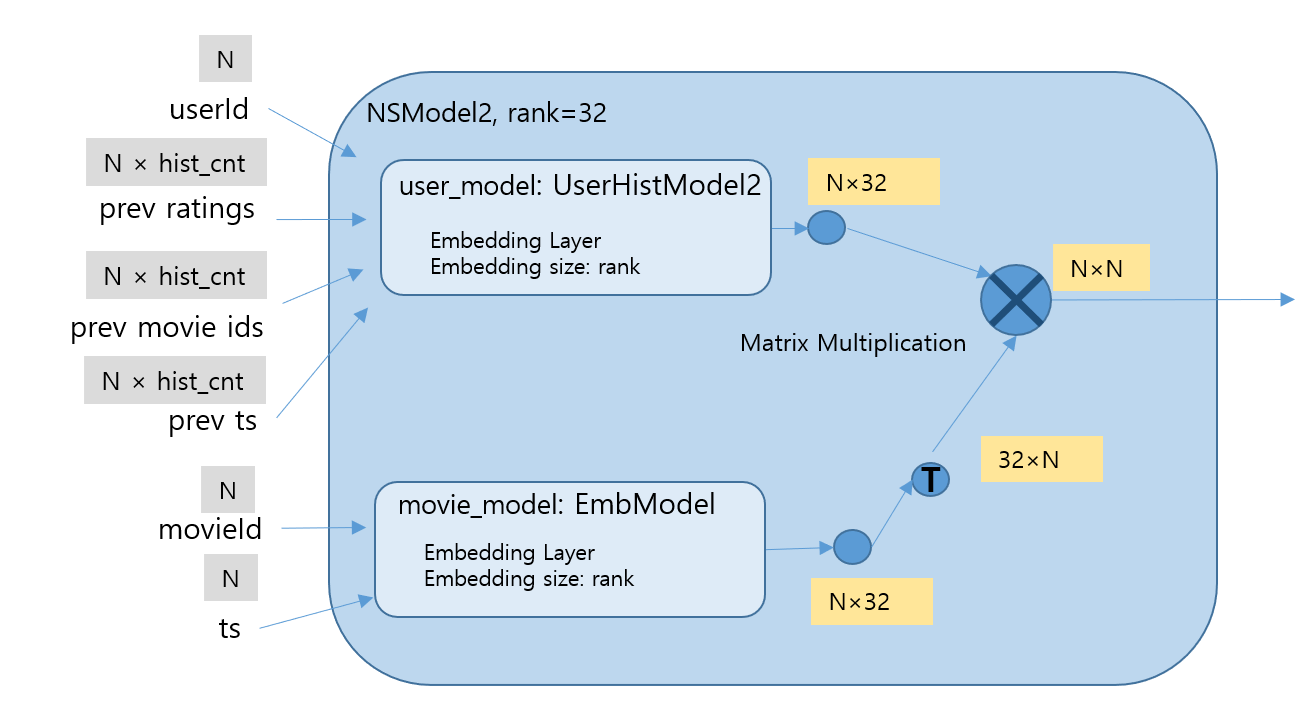

In [26]:
class NSModel2(tf.keras.Model):
    def __init__(self, user_hist_model2, movie_model):
        super().__init__()
        self.user_hist_model2 = user_hist_model2
        self.movie_model = movie_model
        
    def call(self, x, training=False):
        I = self.user_hist_model2(
            x['userId'], 
            x['prev_movieIds'], 
            tf.expand_dims(x['prev_ratings'], axis=-1), 
            x['prev_ts'],
            training=training
        )
        W_prime = self.movie_model(x['movieId'], x['ts'], training=training)
        Logit = tf.matmul(I, W_prime, transpose_b=True) # transpose_b=True, W_prime를 Transpose를 하여 행렬곱을 합니다.
        return Logit

In [27]:
class NSMeanModel(tf.keras.Model):
    def __init__(self, movie_mean_model):
        super().__init__()
        self.movie_mean_model = movie_mean_model
    def call(self, x, training = False):
        I = tf.expand_dims(tf.ones_like(x['userId'], dtype = tf.float32), axis = -1)
        W_prime = self.movie_mean_model(x['movieId'], training = training)
        Logit = tf.matmul(I, W_prime, transpose_b = True)
        return Logit

In [28]:
rank = 64
collection_rank = 8
tf.keras.backend.clear_session()
user_model = rcmd.EmbModel(s_user_cnt.loc[s_user_cnt >=150].index.values, rank)
movie_model = rcmd.EmbModel(s_movie_cnt.loc[s_movie_cnt >= 100].index.values, rank)
movie_info_model = rcmd.MovieInfoModel(df_movieinfo, movie_model, {'collection': collection_rank}, rank)
user_hist_model = rcmd.UserHistModel2(user_model, movie_info_model, rank, rnn='lstm')

ns_model2 = NSModel2(user_hist_model, movie_info_model)
test_input = {
    'userId': tf.constant([1, 2]), 'movieId': tf.constant([3, 4]), 'ts': tf.constant([0, 0], dtype=tf.int64),
    'prev_movieIds': tf.constant([[1, 2], [3, 4]]), 'prev_ratings': tf.constant([[3.0, 4.0], [5.0, 3]]),
    'prev_ts': tf.constant([[1, 2], [3, 4]], dtype = tf.int64)
}

In [29]:
ns_model2(test_input)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.03499584, 0.02446572],
       [0.03525482, 0.02563694]], dtype=float32)>

In [30]:
movie_mean_model = rcmd.EmbModel(s_movie_cnt.loc[s_movie_cnt > 1].index.values, 1)
ns_mean_model = NSMeanModel(movie_mean_model)
ns_mean_model(test_input)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.03351818, 0.0187973 ],
       [0.03351818, 0.0187973 ]], dtype=float32)>

In [31]:
a_model = rcmd.AdditiveModel([ns_model2, ns_mean_model])
a_model(test_input)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.06851402, 0.04326303],
       [0.068773  , 0.04443424]], dtype=float32)>

**Metric**


**Top@K Accuracy**: 예측 가능성이 높은 K번째까지의 아이템이 실제로 선택한 아이템에 있을 확률입니다.

많은 아이템 중에서 가장 가능성이 높은 하나의 아이템를 정답으로 보는 것보다, 

여러 후보군에 정답이 포함되어 있는 것을 바라볼 때 모델의 잠재력을 파악하는 데 도움이 됩니다.

특히, 추천에는 여러 아이템을 보여 준다는 점에서 단일 정답만을 고려하지 않고, 여러 후보군에서

정답이 있을 여부를 파악하는 데 도움이 됩니다.

In [32]:
# TopK를 구하는 예제를 들어 봅니다.
# 출력된 로짓과 정답 클래스가 아래와 같다고 가정합니다.
logit = np.array([
    [2, 1, 3],
    [1, 5, 4],
    [5, 4, 1]
])
y = np.arange(0, 3)
logit, y

(array([[2, 1, 3],
        [1, 5, 4],
        [5, 4, 1]]),
 array([0, 1, 2]))

In [33]:
# 정답이 위치하게 되는 인덱스에 True가 있게 됩니다. 
# True가 첫번째 컬럼에 있다면 첫번째로 가능성이 높은 것으로 예상한 것이 정답이고, 
# True가 두번째 컬럼에 있다면 두번째로 가능성이 높은 것으로 예상한 것이 정답이 됩니다.
(np.argsort(-logit) == np.expand_dims(y, axis=-1))

array([[False,  True, False],
       [ True, False, False],
       [False, False,  True]])

In [34]:
(
    np.sum((np.argsort(-logit) == np.expand_dims(y, axis=-1))[:1]) / 3, # Top@1
    np.sum((np.argsort(-logit) == np.expand_dims(y, axis=-1))[:2]) / 3, # Top@2
    np.sum((np.argsort(-logit) == np.expand_dims(y, axis=-1))[:3]) / 3  # Top@3
)

(0.3333333333333333, 0.6666666666666666, 1.0)

In [35]:
# 평점을 남길 가능상 Top k개 중에 대상 영화가 있는 비율을 구합니다.
# Top@1(==Accuracy), Top@5, Top@10, Top@50, Top@100 Accuracy를 구하도록 설정합니다.
top_k = [1, 5, 10, 50, 100]

In [36]:
np.eye(4)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [37]:
def train(ns_model, hist_cnt = 8, batch_size = 1024, learning_rate=1e-3):
    metric_ce = tf.keras.metrics.Mean() 
    metric_top_k = [tf.keras.metrics.Mean() for i in top_k]

    cce = tf.keras.losses.CategoricalCrossentropy(
        from_logits=True, 
        reduction=tf.keras.losses.Reduction.SUM
    ) # Target의 값은 Dense 형태로 돼있습니다. 그래서 Categorical Crossentropy를 사용합니다.
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    @tf.function(
        input_signature = [
            tf.TensorSpec(shape=(None, ), dtype=tf.int64), # userId: N
            tf.TensorSpec(shape=(None, ), dtype=tf.int64), # movieId: N
            tf.TensorSpec(shape=(None, ), dtype=tf.int64), # ts: N
            tf.TensorSpec(shape=(None, hist_cnt), dtype=tf.int64), # prev_movieIds: Nxhist_cnt
            tf.TensorSpec(shape=(None, hist_cnt), dtype=tf.float32), # prev_ratings: Nxhist_cnt
            tf.TensorSpec(shape=(None, hist_cnt), dtype=tf.int64), # prev_ts: Nxhist_cnt
        ]
    )
    def train_step_softmax(userId, movieId, ts, prev_movieIds, prev_ratings, prev_ts):
        with tf.GradientTape() as tape:
            logits = ns_model({
                'userId': userId, 'movieId': movieId, 'ts': ts, 'prev_movieIds': prev_movieIds, 'prev_ratings': prev_ratings, 'prev_ts': prev_ts
            }, training=True)
            loss = cce(tf.eye(tf.shape(userId)[0]), logits)
            regularization_loss = tf.reduce_sum(ns_model.losses)
            loss = loss + regularization_loss
            loss = tf.identity(loss)
        
        metrics = {
            'loss': loss,
            'regularization_loss': regularization_loss
        }
        # Top-K를 구합니다.
        # 1. 모델에서 출력한 Output(Logit)에서 사용자가 선택했을 가능성이 높은 순으로 정렬합니다. 
        # 2. 정렬한 아이템이 실제로 선정 유무를 기록합니다. 
        # 3. 정답은 첫 번째 행은 0, 그 다음은 1, ... N-1 위치에 있게됩니다.
        prd_correct = tf.cast(
            tf.argsort(-logits, axis=-1) == tf.expand_dims(tf.range(0, tf.shape(userId)[0]), axis=-1), 
            tf.float32)
        # Top_K에 해당하는 수치를 구합니다.
        # K 지점까지 봤을 때 정답이 포함되어 있을 비율을 구합니다.
        for i in top_k:
            metrics['top_{}'.format(i)] = tf.reduce_mean(tf.reduce_sum(prd_correct[:, :i], axis=1))
        variables = ns_model.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        return metrics
    
    with tqdm() as pbar:
        for i in rcmd.hist_set_iter(
            df_train.groupby(df_train['date'].dt.date).sample(frac = 1),
            df_user_hist, hist_cnt, batch_size, pbar, default_rating=rating_train_mean, equal_batch_size=True):
            # 사용자 / 영화 / 추출한 평가이력를 train_step_softmax에 전달합니다.
            loss = train_step_softmax(
                tf.constant(i[0], dtype=tf.int64),
                tf.constant(i[1], dtype=tf.int64),
                tf.constant(i[2], dtype=tf.int64),
                tf.constant(i[3], dtype=tf.int64),
                tf.constant(i[4], dtype=tf.float32),
                tf.constant(i[5], dtype=tf.int64),
            )
            metric_ce.update_state(loss['loss'])
            for j, m in zip(top_k, metric_top_k):
                m.update_state(loss['top_{}'.format(j)])
            # Top1, Top5를 프로그레스바에 출력합니다.
            pbar.set_description(
                "ce {:.3f}, top_1 {:.3f}, top_5 {:.3f}".format(
                    metric_ce.result().numpy(), 
                    metric_top_k[0].result().numpy(),
                    metric_top_k[1].result().numpy()
                )
            )
        
def predict_test(ns_model, batch_size):
    prds = []
    correct = np.expand_dims(np.arange(0, batch_size), axis=-1)
    with tqdm() as pbar:
        for i in rcmd.hist_set_iter(df_test, df_user_hist, hist_cnt, batch_size, pbar, shuffle=False, n_job=1, default_rating=rating_train_mean, equal_batch_size=False):
            prd = ns_model({
                'userId': tf.constant(i[0]), 
                'movieId': tf.constant(i[1]), 
                'ts': tf.constant(i[2]), 
                'prev_movieIds': tf.constant(i[3]), 
                'prev_ratings': tf.constant(i[4]),
                'prev_ts': tf.constant(i[5])
            }).numpy()
            # 파악한 top_k에 가장 큰 지점까지의 정답 포함여부를 남깁니다.
            prds.append((np.argsort(-prd, axis=-1) == correct[:prd.shape[0]])[:, :top_k[-1]])
    return np.vstack(prds)

In [38]:
model_filename = os.path.join('model', 'ns2.pkl')

"""
if not os.path.exists(model_filename):
    o = gdown.download("https://drive.google.com/uc?id=1PzHyS1j7_Laq0dU_q_V-4PAU63R9iBEY", quiet=False)
    os.rename(o, model_filename)
"""

if not os.path.isfile(model_filename):
    rank = 32
    collection_rank = 8
    rnn = 'lstm'
    tf.keras.backend.clear_session()
    user_idx = s_user_cnt.loc[s_user_cnt >=150].index.values
    movie_idx = s_movie_cnt.loc[s_movie_cnt >= 100].index.values
    user_model = rcmd.EmbModel(user_idx, rank)
    movie_model = rcmd.EmbModel(movie_idx, rank)
    movie_info_model = rcmd.MovieInfoModel(df_movieinfo, movie_model, {'collection': collection_rank}, rank)
    user_hist_model = rcmd.UserHistModel2(user_model, movie_info_model, rank, rnn=rnn)
    ns2_model = NSModel2(user_hist_model, movie_info_model)

    movie_mean_model = rcmd.EmbModel(s_movie_cnt.loc[s_movie_cnt > 1].index.values, 1)
    ns_mean_model = NSMeanModel(movie_mean_model)
    a_model = rcmd.AdditiveModel([ns_model2, ns_mean_model])
    
    # 학습을 수행하는 루틴입니다.
    hist_cnt = 8
    batch_size= 1024
    epochs=10
    
    cols = ['top_{}'.format(i) for i in top_k]
    verbose=True
    topk_epoch, topk_by_userCnt, topk_by_movieCnt = list(), list(), list()
    # epoch 반복문
    for i in range(epochs):
        train(a_model, hist_cnt, batch_size, learning_rate=5e-5)
        # epoch 마다 검증 결과를 출력해줍니다.
        if verbose:
            prds = predict_test(a_model, batch_size)
            # 주어진 top_k에 대한 성능을 종합합니다.
            df_topk = pd.DataFrame(
                np.vstack([np.sum(prds[:, :j], axis=1) for j in top_k]).T,
                index=df_test.index, columns=cols
            )
            topk_epoch.append(df_topk.mean().rename(i + 1))
            topk_by_userCnt.append(
                df_topk.groupby(s_user_type, observed=True)[cols].mean().map(
                    lambda x: '{:.4f}'.format(x)
                ).apply(lambda x: ','.join(x), axis=1).rename(i + 1)
            )
            topk_by_movieCnt.append(
                df_topk.groupby(s_movie_type, observed=True)[cols].mean().map(
                    lambda x: '{:.4f}'.format(x)
                ).apply(lambda x: ','.join(x), axis=1).rename(i + 1)
            )
            clear_output()
            display(pd.concat(topk_epoch, axis=1).T)
            display(pd.concat(topk_by_userCnt, axis=1).T)
            display(pd.concat(topk_by_movieCnt, axis=1).T)
    with open(model_filename, 'wb') as f:
        pickle.dump({
            'rank': rank,
            'collection_rank': collection_rank,
            'user_idx': user_idx,
            'movie_idx': movie_idx,
            'movieInfo': df_movieinfo,
            'topk_epoch': topk_epoch,
            'topk_by_userCnt': topk_by_userCnt,
            'topk_by_movieCnt': topk_by_movieCnt,
            'weights': a_model.get_weights(),
            'hist_cnt': hist_cnt,
            'rnn': rnn
        }, f)
else:
    # 제공한 ns_model 학습 결과를 불러 옵니다.
    # ns2.pkl은 강의 데이터셋이 공유된 Google Drive상에 있습니다.
    with open(model_filename, 'rb') as f:
        ns2 = pickle.load(f)
    topk_epoch, topk_by_userCnt, topk_by_movieCnt = ns2['topk_epoch'], ns2['topk_by_userCnt'], ns2['topk_by_movieCnt']
    display(pd.concat(topk_epoch, axis=1).T)
    display(pd.concat(topk_by_userCnt, axis=1).T)
    display(pd.concat(topk_by_movieCnt, axis=1).T)
    rank = ns2['rank']
    collection_rank = ns2['collection_rank']
    rnn = ns2['rnn']
    tf.keras.backend.clear_session()
    user_model = rcmd.EmbModel(ns2['user_idx'], rank)
    movie_idx = ns2['movie_idx']
    movie_model = rcmd.EmbModel(movie_idx, rank)
    movie_info_model = rcmd.MovieInfoModel(ns2['movieInfo'], movie_model, {'collection': collection_rank}, rank)
    user_hist_model = rcmd.UserHistModel2(user_model, movie_info_model, rank, rnn=rnn)
    ns2_model = NSModel2(user_hist_model, movie_info_model)

    movie_mean_model = rcmd.EmbModel(s_movie_cnt.loc[s_movie_cnt > 1].index.values, 1)
    ns_mean_model = NSMeanModel(movie_mean_model)
    a_model = rcmd.AdditiveModel([ns_model2, ns_mean_model])
    
    # ns_model의 Layer를 build 하기 위해 model을 호출합니다.
    a_model({
        'userId': tf.constant([1, 2]), 'movieId': tf.constant([3, 4]), 'ts': tf.constant([0, 0], dtype=tf.int64),
        'prev_movieIds': tf.constant([[1, 2], [3, 4]]), 'prev_ratings': tf.constant([[3.0, 4.0], [5.0, 3]]),
        'prev_ts': tf.constant([[1, 2], [3, 4]], dtype = tf.int64)
    })
    
    a_model.set_weights(ns2['weights'])

,top_1,top_5,top_10,top_50,top_100
1,0.015753,0.065838,0.114548,0.338062,0.485501
2,0.017427,0.072447,0.125119,0.357281,0.504286
3,0.019104,0.077841,0.132602,0.371121,0.516963
4,0.019919,0.080736,0.137317,0.378185,0.523237
5,0.020790,0.083971,0.141549,0.385144,0.530230
6,0.021495,0.086206,0.144481,0.388653,0.533281
7,0.021789,0.087196,0.146556,0.392107,0.535355
8,0.021682,0.088150,0.148302,0.395314,0.538647
9,0.021844,0.087663,0.147747,0.394609,0.537254
10,0.022514,0.090531,0.151910,0.399765,0.541883


userCnt,"[0.0, 1.0)","[1.0, 150.0)","[150.0, 500.0)","[500.0, 1000.0)","[1000.0, inf)"
1,"0.0152,0.0647,0.1137,0.3410,0.4913","0.0128,0.0542,0.0948,0.2866,0.4229","0.0155,0.0605,0.1033,0.2989,0.4307","0.0167,0.0707,0.1202,0.3307,0.4687","0.0214,0.0831,0.1397,0.3870,0.5401"
2,"0.0165,0.0711,0.1246,0.3616,0.5113","0.0144,0.0596,0.1026,0.3008,0.4360","0.0170,0.0664,0.1114,0.3171,0.4518","0.0202,0.0772,0.1289,0.3474,0.4839","0.0246,0.0930,0.1529,0.4010,0.5530"
3,"0.0182,0.0762,0.1320,0.3760,0.5239","0.0162,0.0654,0.1095,0.3115,0.4452","0.0186,0.0720,0.1198,0.3319,0.4666","0.0220,0.0825,0.1352,0.3583,0.4985","0.0265,0.1002,0.1614,0.4137,0.5654"
4,"0.0189,0.0790,0.1364,0.3828,0.5296","0.0167,0.0676,0.1135,0.3177,0.4481","0.0196,0.0749,0.1242,0.3397,0.4757","0.0230,0.0853,0.1424,0.3673,0.5078","0.0277,0.1039,0.1678,0.4217,0.5730"
5,"0.0200,0.0827,0.1411,0.3905,0.5371","0.0168,0.0703,0.1186,0.3240,0.4542","0.0204,0.0769,0.1275,0.3441,0.4808","0.0228,0.0875,0.1441,0.3722,0.5148","0.0285,0.1059,0.1700,0.4268,0.5787"
6,"0.0207,0.0849,0.1441,0.3938,0.5404","0.0184,0.0725,0.1201,0.3269,0.4571","0.0202,0.0789,0.1307,0.3476,0.4826","0.0229,0.0897,0.1463,0.3764,0.5179","0.0294,0.1086,0.1734,0.4317,0.5814"
7,"0.0210,0.0860,0.1463,0.3977,0.5424","0.0182,0.0725,0.1215,0.3309,0.4577","0.0211,0.0800,0.1326,0.3490,0.4845","0.0236,0.0905,0.1476,0.3785,0.5207","0.0297,0.1097,0.1753,0.4344,0.5844"
8,"0.0208,0.0871,0.1485,0.4017,0.5467","0.0179,0.0740,0.1235,0.3321,0.4606","0.0209,0.0809,0.1326,0.3495,0.4834","0.0233,0.0897,0.1486,0.3801,0.5220","0.0304,0.1103,0.1759,0.4361,0.5853"
9,"0.0208,0.0860,0.1473,0.3999,0.5439","0.0184,0.0733,0.1241,0.3314,0.4590","0.0214,0.0816,0.1336,0.3523,0.4848","0.0236,0.0916,0.1479,0.3823,0.5265","0.0309,0.1119,0.1782,0.4391,0.5890"
10,"0.0216,0.0896,0.1524,0.4060,0.5493","0.0196,0.0758,0.1266,0.3356,0.4634","0.0215,0.0824,0.1352,0.3550,0.4878","0.0241,0.0934,0.1499,0.3844,0.5277","0.0311,0.1124,0.1799,0.4418,0.5913"


movieCnt,"[0.0, 1.0)","[1.0, 100.0)","[100.0, 1000.0)","[1000.0, 5000.0)","[5000.0, 10000.0)","[10000.0, inf)"
1,"0.0223,0.0910,0.1581,0.4543,0.5987","0.0239,0.0945,0.1611,0.4435,0.6052","0.0213,0.0824,0.1366,0.3623,0.5169","0.0169,0.0676,0.1155,0.3260,0.4664","0.0139,0.0586,0.1022,0.3002,0.4395","0.0120,0.0546,0.0986,0.3180,0.4671"
2,"0.0248,0.1009,0.1718,0.4695,0.6132","0.0261,0.0992,0.1657,0.4476,0.6048","0.0237,0.0857,0.1384,0.3581,0.5090","0.0203,0.0807,0.1347,0.3550,0.4947","0.0151,0.0645,0.1118,0.3265,0.4712","0.0126,0.0592,0.1086,0.3403,0.4889"
3,"0.0272,0.1067,0.1768,0.4734,0.6211","0.0279,0.1075,0.1779,0.4635,0.6216","0.0270,0.0973,0.1540,0.3840,0.5349","0.0225,0.0880,0.1445,0.3712,0.5086","0.0145,0.0625,0.1078,0.3240,0.4701","0.0141,0.0637,0.1156,0.3551,0.5012"
4,"0.0298,0.1147,0.1899,0.4961,0.6445","0.0284,0.1106,0.1834,0.4715,0.6289","0.0303,0.1049,0.1651,0.3977,0.5477","0.0229,0.0900,0.1473,0.3773,0.5158","0.0145,0.0624,0.1087,0.3236,0.4688","0.0146,0.0661,0.1196,0.3615,0.5057"
5,"0.0306,0.1185,0.1943,0.5011,0.6448","0.0264,0.1029,0.1723,0.4553,0.6140","0.0338,0.1154,0.1793,0.4194,0.5683","0.0235,0.0927,0.1521,0.3848,0.5230","0.0149,0.0645,0.1121,0.3329,0.4790","0.0155,0.0698,0.1239,0.3677,0.5123"
6,"0.0309,0.1215,0.1985,0.5106,0.6540","0.0277,0.1080,0.1781,0.4615,0.6206","0.0344,0.1163,0.1800,0.4198,0.5680","0.0243,0.0953,0.1554,0.3889,0.5271","0.0151,0.0650,0.1124,0.3340,0.4802","0.0163,0.0722,0.1274,0.3715,0.5152"
7,"0.0315,0.1198,0.1972,0.5114,0.6526","0.0266,0.1052,0.1748,0.4559,0.6146","0.0367,0.1233,0.1894,0.4331,0.5800","0.0244,0.0953,0.1562,0.3906,0.5284","0.0165,0.0690,0.1185,0.3391,0.4835","0.0160,0.0719,0.1280,0.3743,0.5161"
8,"0.0301,0.1171,0.1921,0.4969,0.6343","0.0255,0.1010,0.1680,0.4386,0.5928","0.0360,0.1219,0.1878,0.4299,0.5752","0.0251,0.0978,0.1589,0.3954,0.5332","0.0157,0.0677,0.1181,0.3402,0.4844","0.0162,0.0748,0.1332,0.3849,0.5287"
9,"0.0325,0.1221,0.2011,0.5150,0.6570","0.0271,0.1079,0.1773,0.4588,0.6177","0.0366,0.1228,0.1884,0.4275,0.5728","0.0235,0.0928,0.1522,0.3820,0.5166","0.0148,0.0632,0.1117,0.3298,0.4711","0.0169,0.0755,0.1345,0.3884,0.5317"
10,"0.0316,0.1209,0.1992,0.5107,0.6514","0.0267,0.1066,0.1739,0.4499,0.6042","0.0373,0.1244,0.1922,0.4321,0.5766","0.0247,0.0978,0.1596,0.3962,0.5320","0.0158,0.0705,0.1228,0.3496,0.4928","0.0176,0.0775,0.1369,0.3880,0.5301"


In [39]:
df_movie.join(
    pd.Series(movie_mean_model.get_weights()[0][1:, 0], s_movie_cnt.loc[s_movie_cnt > 1].index.values, name = 'm')
).join(df_ratings['movieId'].value_counts().rename('cnt')).sort_values('cnt', ascending = False).dropna().iloc[:50]

,title,genres,release_date,m,cnt
movieId,,,,,
318,"Shawshank Redemption, The (1994)",Crime|Drama,780278400000000000,-0.099959,102929.0
356,Forrest Gump (1994),Comedy|Drama|Romance|War,772329600000000000,0.572556,100296.0
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,779155200000000000,0.152271,98409.0
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,922752000000000000,0.075567,93808.0
593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,666489600000000000,0.454680,90330.0
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,233366400000000000,0.532305,85010.0
2959,Fight Club (1999),Action|Crime|Drama|Thriller,939945600000000000,0.017272,77332.0
480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,739756800000000000,0.524675,75233.0
527,Schindler's List (1993),Drama|War,755913600000000000,-0.129997,73849.0


테스트셋에서 

**첫 번째**테이블 Epoch 별 Top@1, @5, @10, @50, @100 성능 입니다.

**두 번째**테이블은 Train에 평점을 남긴 수에 따른 사용자의 Top@1, @5, @10, @50, @100 성능 입니다.

**세 번째**테이블은 Train에 평점이 남겨진 수에 따른 영화의 Top@1, @5, @10, @50, @100 성능 입니다.


### ns2_model을 테스트해봅니다.

In [40]:
hist_cnt = 8
prds = predict_test(a_model, 1024)
cols = ['top_{}'.format(i) for i in top_k]
df_topk = pd.DataFrame(
    np.vstack([np.sum(prds[:, :i], axis=1) for i in top_k]).T,
    index=df_test.index, columns=cols
)
# Top@K 평가입니다.
df_topk.mean()

100%|█████████████████████████████████████████████████████████████████████████████████| 966/966 [01:16<00:00, 12.56it/s]


top_1      0.022636
top_5      0.090792
top_10     0.151781
top_50     0.399716
top_100    0.541947
dtype: float64

In [41]:
# Train에  등장한 빈도수 별 사용자의 성능 평가 입니다.
df_topk.groupby(s_user_type, observed=True)[cols].mean()

,top_1,top_5,top_10,top_50,top_100
userCnt,,,,,
"[0.0, 1.0)",0.021789,0.089966,0.152449,0.406027,0.549347
"[1.0, 150.0)",0.019008,0.075510,0.125512,0.335018,0.464231
"[150.0, 500.0)",0.021624,0.082493,0.134615,0.355050,0.487513
"[500.0, 1000.0)",0.024603,0.093357,0.150331,0.384037,0.529566
"[1000.0, inf)",0.030901,0.112205,0.179094,0.441413,0.590271


In [42]:
# Train에  등장한 빈도수 별 영화의 성능 평가 입니다.
df_topk.groupby(s_movie_type, observed=True)[cols].mean()

,top_1,top_5,top_10,top_50,top_100
movieCnt,,,,,
"[0.0, 1.0)",0.030604,0.121152,0.199303,0.510870,0.651668
"[1.0, 100.0)",0.026469,0.106300,0.174006,0.449846,0.604888
"[100.0, 1000.0)",0.037251,0.124653,0.191545,0.432019,0.576474
"[1000.0, 5000.0)",0.025032,0.097976,0.159549,0.396218,0.532150
"[5000.0, 10000.0)",0.016290,0.070538,0.122564,0.349563,0.492997
"[10000.0, inf)",0.017706,0.077952,0.136884,0.387962,0.530000


In [45]:
# Embedding Projector로 영화 Embedding을 시각화해봅니다.
from tensorboard.plugins import projector

# Set up a logs directory, so Tensorboard knows where to look for files.
log_dir='logs/m32m_ns2/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
known = []
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for i in movie_idx:
        if i in m32m['movie_info_kr']:
            f.write("{}\n".format(df_movie.loc[i, 'title']))
            known.append(i)
        
weights =  tf.Variable(
    movie_info_model(tf.constant(known), tf.constant(df_ratings.groupby(['movieId'])['ts'].mean().loc[known].astype('int64'), dtype=tf.int64))
)
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)
%load_ext tensorboard

In [43]:
# %tensorboard --logdir logs/m32m_ns2/ --bind_all